# Learning Objectives

Use few-shot prompting to build LLM applications for generation tasks.


# Setup

In [1]:
!pip install -q openai==1.23.2 datasets evaluate bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.7 MB/s eta 0:00:00


In [17]:
import pandas as pd

from openai import OpenAI
from datasets import load_dataset
from google.colab import userdata
from evaluate import load
from tqdm import tqdm

In [3]:
anyscale_api_key = userdata.get('anyscale_api_key')

In [4]:
client = OpenAI(
    base_url="https://api.endpoints.anyscale.com/v1",
    api_key=anyscale_api_key
)

In [5]:
model_name = 'mlabonne/NeuralHermes-2.5-Mistral-7B'

# Text - Text Generation Tasks

## Overview

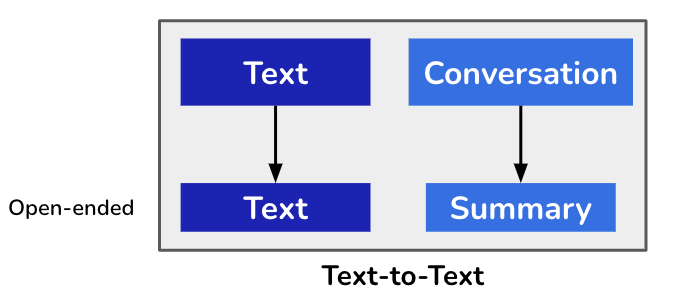

Text-to-Text generation problems are another class of important problems that LLMs solve effectively. In this notebook, we present an approach to design and evaluate prompts for text-to-text tasks using summarization as an example. The approach followed in this notebook can be extended to any other text-to-text task as well.

We begin by presenting a workflow for prompt design and evaluation for text generation tasks.

## Workflow

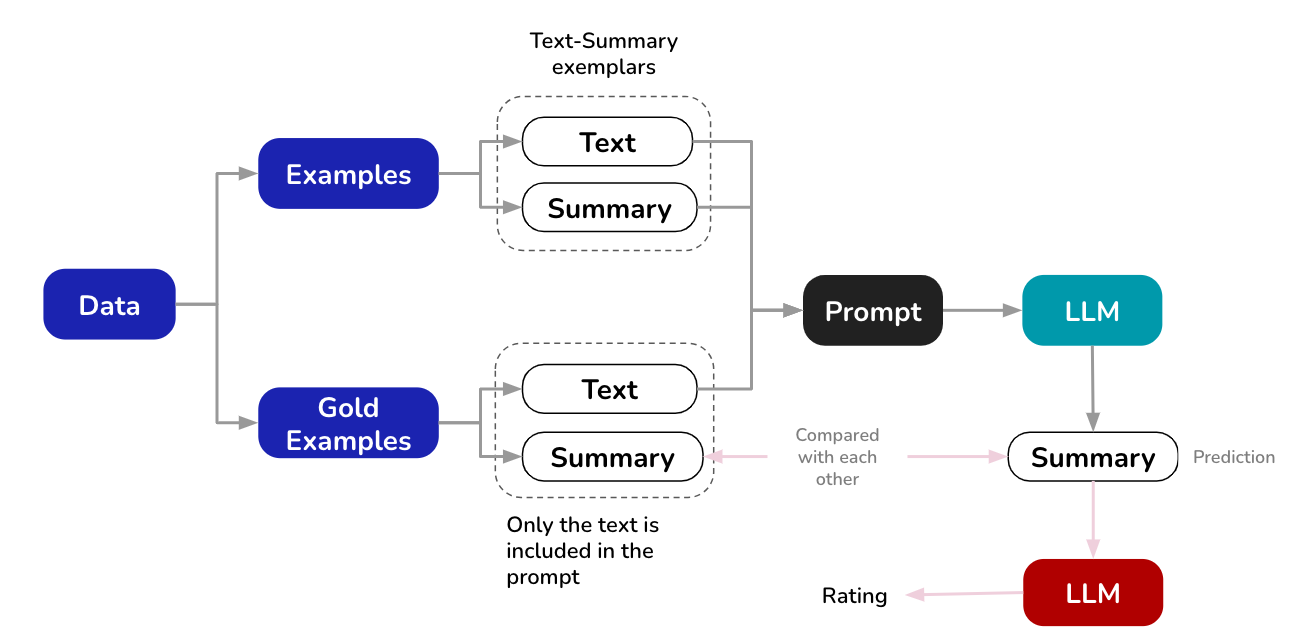

As indicated in the above figure, the data used to achieve text generation tasks comprises examples and gold examples. Examples are input-output exemplars included in the prompt to prime it for expected output generation. Gold examples are inputs for which we have ground truth available and predictions from the LLM for the inputs is compared with the ground truths. We choose the best *prompt* as the one that scores high on predefined metrics on the set of gold examples. Unlike classification though, here we have to contend with subjective output. This complicates the evaluation process (including the difficulty in collecting human generated baselines), and it is common to use LLMs to evaluate the quality of outputs (referred to as LLM-as-a-judge).  

## Evaluation

Given the subjective nature of text generation, there are two ways in which generation tasks could be evaluated.

- When human annotations are available, evaluation is done using BERTScore. BERTScore is an automatic evaluation metric for text generation tasks that leverages the pre-trained contextual embeddings from BERT to compute the semantic similarity between the generated text (candidate) and the reference text, rather than relying on exact token matches.

- When human annotations are not available, we use another LLM to rate the performance of the LLM used in the generation task (see figure below for an example in case of summarization). This method of using LLMs to evaluate LLMs is usualy referred to as LLM-as-a-judge. When LLMs are used to evaluate output, the system message should clearly define the rubrics used for evaluation and the key aspects of the output that should be evaluated. The advantage of using LLMs as judges is that we do not need human baselines (that are costly to collect), while writing down the rubrics for assessment is usually an easier task.

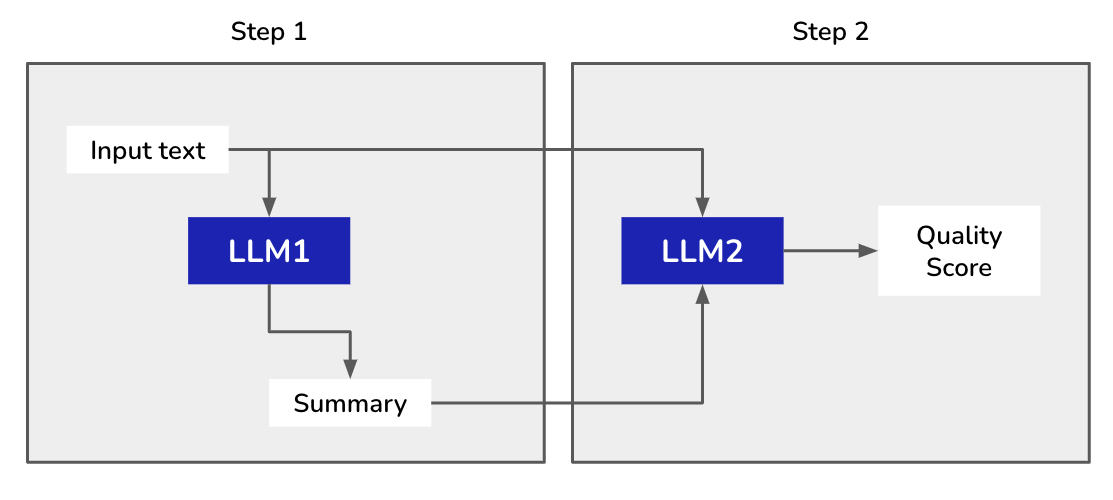

Let us now implement this workflow for diaogue summarization on a sample of conversations.

# Summarization

## Prompt Design

We will design a few-shot prompt for summarization. We first assemble a set of examples (input-output exemplars) as a part of the few-shot prompt. Then we create the prompt in the Anyscale API format.

To evaluate the performance of the *prompt* we will use a set of *gold examples*, that is, a set of examples that is not presented to the model as a part of the prompt.  

**Examples and Gold Examples**

In [6]:
dataset = load_dataset("pgurazada1/dialogsum")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating gold_examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

**Assembling the prompt**

Let us now assemble 4 examples from this dataset of 32 dialogue examples. We also collect the 32 gold examples.

In [7]:
dialogue_summary_examples_df = dataset['examples'].to_pandas()
dialogue_summary_gold_examples_df = dataset['gold_examples'].to_pandas()

In [8]:
examples_df = dialogue_summary_examples_df.sample(4)

In [9]:
examples_df

dialogue  \
6   #Person1#: The boys in this picture look aweso...   
3   #Person1#: Well hi there. What are you looking...   
11  #Person1#: The performance is amazing. I'm cur...   
15  #Person1#: Excuse me mam, can you tell me how ...   

                                              summary  
6   #Person1#'s interested in the band R5. Susan i...  
3   #Person2# is looking around in the store and #...  
11  #Person1# thinks the performance is amazing an...  
15  #Person1# asks #Person2# how to get to Son Col...

We need to iterate over the rows of the examples DataFrame to append these examples as `user` and `assistant` messages to the few-shot prompt. We achieve this using the `iterrows` method.

In [10]:
for index, row in examples_df.iterrows():
    print('Example Dialogue:')
    print(row[0])
    print('Example Summary:')
    print(row[1])
    break

Example Dialogue:
#Person1#: The boys in this picture look awesome, Susan. Who are they?
#Person2#: There are members of a band called R5. Their music is really popular right now online. I'm a big fan. This boy here is Ross and these here are Rocky, Riker and Rydel Lynch. Oh, and this is Ellington Ratliff.
#Person1#: So who is this boy in the middle again?
#Person2#: That's Ross. He's the lead singer and plays the rhythm guitar.
#Person1#: What do the others do in the band?
#Person2#: Rocky is a guitarist. Rydell plays keyboard and Ratliff plays the drums.
#Person1#: Do you have one of their albums?
#Person2#: Yes, I just bought their main album last month. Do you want to borrow it? You can take it home and listen to it.
#Person1#: Yes, I'd love to.
Example Summary:
#Person1#'s interested in the band R5. Susan introduces the band to #Person1# and lends #Person1# the main album.


In [11]:
system_message = """
Summarize the dialogue mentioned in the user input. Be specific and concise in your summary.
"""

In [12]:
few_shot_prompt = [{'role':'system', 'content': system_message}]

We need to iterate over the rows of the examples DataFrame to append these examples as `user` and `assistant` messages to the few-shot prompt. We achieve this using the `iterrows` method.

In [13]:
for index, row in examples_df.iterrows():
    user_input_example = row[0]
    assistant_output_example = row[1]

    few_shot_prompt.append(
        {
            'role': 'user',
            'content': user_input_example
        }
    )

    few_shot_prompt.append(
        {
            'role': 'assistant',
            'content': assistant_output_example
        }
    )

In [14]:
few_shot_prompt

[{'role': 'system',
  'content': '\nSummarize the dialogue mentioned in the user input. Be specific and concise in your summary.\n'},
 {'role': 'user',
  'content': "#Person1#: The boys in this picture look awesome, Susan. Who are they?\n#Person2#: There are members of a band called R5. Their music is really popular right now online. I'm a big fan. This boy here is Ross and these here are Rocky, Riker and Rydel Lynch. Oh, and this is Ellington Ratliff.\n#Person1#: So who is this boy in the middle again?\n#Person2#: That's Ross. He's the lead singer and plays the rhythm guitar.\n#Person1#: What do the others do in the band?\n#Person2#: Rocky is a guitarist. Rydell plays keyboard and Ratliff plays the drums.\n#Person1#: Do you have one of their albums?\n#Person2#: Yes, I just bought their main album last month. Do you want to borrow it? You can take it home and listen to it.\n#Person1#: Yes, I'd love to."},
 {'role': 'assistant',
  'content': "#Person1#'s interested in the band R5. Susan

We now have 4 examples in the few shot prompt that is ready for use. Before we deploy this prompt, we need to get an estimate of the performance of this prompt. Here is where we need gold examples to get a baseline estimate.

## Evaluation

In [15]:
predictions, ground_truths = [], []

In [16]:
for index, row in tqdm(dialogue_summary_gold_examples_df.iterrows()):
    gold_dialogue = row[0]
    gold_summary = row[1]

    user_input = [{'role':'user', 'content': gold_dialogue}]

    response = client.chat.completions.create(
        model=model_name,
        messages=few_shot_prompt + user_input
    )

    predictions.append(response.choices[0].message.content)
    ground_truths.append(gold_summary)

32it [02:13,  4.18s/it]


We now have a set of summaries from the LLM and we want to understand if the summary is a good reflection of the content of the dialogue. To accomplish this, we could use a more powerful model to act as a judge. We also have human baseline summaries for the same conversation and we could use BERTScore to compare the predictions and ground truths. Let us now run evaluations using both these methods.

**BERTScore**

In [18]:
bertscore = load("bertscore")

In [19]:
results = bertscore.compute(
    predictions=predictions,
    references=ground_truths,
    lang="en"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
sum(results['f1'])/len(results['f1'])

0.8989088013768196

The above score indicates that the summarization was of very high quality,

**LLM-as-a-judge**

A general prompt that can be used when LLMs are used as judges is presented below.

In [24]:
rater_model = "mistralai/Mixtral-8x7B-Instruct-v0.1"

In [25]:
rater_system_message = """
You are tasked with rating AI-generated summaries of dialogues based on the given metric.
You will be presented a dialogue and an AI generated summary of the dialogue as the input.
In the input, the dialogue will begin with ###Dialogue while the AI generated summary will begin with ###Summary.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the summary.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The summary should cover all the aspects that are majorly being discussed in the dialogue.

Instructions:
1. First write down the steps that are needed to evaluate the summary as per the metric.
2. Give a step-by-step explanation if the summary adheres to the metric considering the dialogues as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the summary using the evaluaton criteria and assign a score.
"""

Notice how the rubric is clearly defined. Also the metric used to judge the output is clearly delineated. This prompt can be readily adapted to create multiple raters,e ach focusing on one metric.

In [26]:
rater_user_message_template = """
###Dialogue
{dialogue}

###Summary
{summary}
"""

In [27]:
ratings = []

In [28]:
for gold_dialogue, prediction in tqdm(zip(dialogue_summary_gold_examples_df.dialogue, predictions)):

    rater_prompt = [
        {'role': 'system',
         'content': rater_system_message
        },
        {
            'role': 'user',
            'content': rater_user_message_template.format(
                dialogue=gold_dialogue,
                summary=prediction
            )
        }
    ]

    response = client.chat.completions.create(
        model=rater_model,
        messages=rater_prompt
    )

    ratings.append(response.choices[0].message.content)

32it [03:05,  5.79s/it]


In [30]:
pd.DataFrame(
    {'dialogue': dialogue_summary_gold_examples_df.dialogue,
     'prediction': predictions,
     'rating': ratings
     }
)

dialogue  \
0   #Person1#: do you have any plans for dinner to...   
1   #Person1#: Are you an art aficionado?\n#Person...   
2   #Person1#: Sally,here is a letter for us. It's...   
3   #Person1#: So, did I tell you about my New Yea...   
4   #Person1#: I'm coming to pick up my ticket. Th...   
5   #Person1#: Hi, Dan, I'm calling to check on th...   
6   #Person1#: Tom, I've got good news for you.\n#...   
7   #Person1#: How did your company's fundraiser g...   
8   #Person1#: OK, Mrs Thomas. I finished cleaning...   
9   #Person1#: Mr. Wilson. We are very regretful a...   
10  #Person1#: Hi, Fanny.\n#Person2#: Hi, Andy.\n#...   
11  #Person1#: You mustn't touch the wet paint, Bi...   
12  #Person1#: Tomorrow is Mike's birthday. I have...   
13  #Person1#: Is anybody in?\n#Person2#: How can ...   
14  #Person1#: Would you like to go to the party t...   
15  #Person1#: Welcome to Danny's, may I take your...   
16  #Person1#: Good morning. What can I do for you...   
17  #Person1#: Excuse me, could you tell me where ...   
18  #Person1#: Excuse me. What's happened? What pl...   
19  #Person1#: It's partly your own fault. You sho...   
20  #Person1#: Hi, I made a reservation for a mid-...   
21  #Person1#: I think spring is finally here.\n#P...   
22  #Person1#: Would you please recommend some Chi...   
23  #Person1#: John? It's Susan Miller.\n#Person2#...   
24  #Person1#: Were you born in Los Angeles?\n#Per...   
25  #Person1#: Well, I'd better get back to work. ...   
26  #Person1#: Hello, this is Francis.\n#Person2#:...   
27  #Person1#: Brian, do you know how to speak Eng...   
28  #Person1#: Honey, of course I forgive you! I l...   
29  #Person1#: My throat is really dry.\n#Person2#...   
30  #Person1#: Hello? Hello?\n#Person2#: ...\n#Per...   
31  #Person1#: I have to go up to London for a cou...   

                                           prediction  \
0   #Person1# and #Person2# discuss their dinner p...   
1   #Person1# is an art lover, especially of abstr...   
2   #Person1# gives a letter from Tom to #Person2#...   
3   #Person1# decides to go on a diet for New Year...   
4   #Person1# is picking up their ticket and #Pers...   
5   #Person1# checks on the order of 100 computers...   
6   #Person1# shares with Tom that his novel has w...   
7   #Person1# asks about the company's fundraiser ...   
8   #Person1# cleans up the yard and front steps a...   
9   #Person1# apologizes for the mistakes made in ...   
10  #Person1# and #Person2# are having a conversat...   
11  #Person1# and #Person2# discuss touching wet p...   
12  #Person1# mentions Mike's birthday party and c...   
13  #Person1# complains about a headache and feeli...   
14  #Person1# informs #Person2# about Ruojia's mar...   
15  #Person2# orders a turkey sandwich with cheese...   
16  #Person2# is troubled by the noise in the room...   
17  #Person1# is looking for Peking University loc...   
18  #Person1# shares their difficulty of sleeping ...   
19  #Person1# is discussing the fault of allowing ...   
20  #Person1# made a reservation for a mid-size ve...   
21  #Person1# and #Person2# discuss the weather du...   
22  #Person2# suggests trying Moutan wine and reco...   
23  Susan Miller calls John and inquires about a m...   
24  #Person2# was born in Chicago and grew up in W...   
25  #Person1# and #Person2# have work and discuss ...   
26  #Person1# and #Person2# discuss when to work o...   
27  #Person1# talks to #Person2# about his English...   
28  #Person1# forgives #Person2# and reveals they ...   
29  #Person1# feels thirsty and considers getting ...   
30  #Person1# is receiving unwanted calls from #Pe...   
31  #Person1# proposed going to London by train an...   

                                               rating  
0    Steps to evaluate the summary:\n\n1. Identify...  
1    Steps to evaluate the summary:\n\n1. Identify...  
2    1. The steps to evaluate the summary as per t...  
3    Steps to evaluate the summary as per the metr...  
4

These detailed ratings could be used to diagnose issues with the prompt or the model used.

# Next Steps

After a few-shot prompt is assembled and evaluated, the prompt is wrapped within a server and deployed.

In [ ]:
# @title Dialogue summarizer

dialogue = "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today? #Person2#: I found it would be a good idea to get a check-up. #Person1#: Yes, well, you haven't had one for 5 years. You should have one every year. #Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor? #Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good. #Person2#: Ok. #Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith? #Person2#: Yes. #Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit. #Person2#: I've tried hundreds of times, but I just can't seem to kick the habit. #Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave. #Person2#: Ok, thanks doctor." # @param {type:"string"}

system_message = """
Summarize the dialogue mentioned in the user input. Be specific and concise in your summary.
"""

user_input = [{'role':'user', 'content': dialogue}]

few_shot_prompt = [{'role':'system', 'content': system_message}]

for index, row in dialogue_summary_examples_df.sample(4).iterrows():
    example_dialogue = row[0]
    example_summary = row[1]

    few_shot_prompt.append(
        {
            'role': 'user',
            'content': example_dialogue
        }
    )

    few_shot_prompt.append(
        {
            'role': 'assistant',
            'content': example_summary
        }
    )

response = client.chat.completions.create(
    model=model_name,
    messages=few_shot_prompt + user_input
)

print(response.choices[0].message.content)


#Person1#, Doctor Hawkins, meets with #Person2#, Mr. Smith, who came for a check-up. They discuss the importance of annual checkups, and the negative effects of smoking. Doctor Hawkins offers support for quitting smoking.


In [ ]:
example_dialogue = """
#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today? #Person2#: I found it would be a good idea to get a check-up. #Person1#: Yes, well, you haven't had one for 5 years. You should have one every year. #Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor? #Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good. #Person2#: Ok. #Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith? #Person2#: Yes. #Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit. #Person2#: I've tried hundreds of times, but I just can't seem to kick the habit. #Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave. #Person2#: Ok, thanks doctor.

"""

# Datasets for practise

## Government Reports

In [33]:
govt_report_data = load_dataset("pgurazada1/govreport")

Generating examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating gold_examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

In [46]:
govt_report_data

DatasetDict({
    examples: Dataset({
        features: ['report', 'summary'],
        num_rows: 32
    })
    gold_examples: Dataset({
        features: ['report', 'summary'],
        num_rows: 32
    })
})

In [34]:
govt_report_data['examples'].to_pandas().sample(4)

report  \
19  The Elementary and Secondary Education Act (ES...   
21  The Democratic Party of Japan (DPJ) defeated t...   
0   To obtain information on the number and kinds ...   
5   BIA administers funding for the operation, mai...   

                                              summary  
19  The Elementary and Secondary Education Act (ES...  
21  In a historic landslide victory, on August 30,...  
0   To ensure the completeness and accuracy of the...  
5   The Bureau of Indian Affairs (BIA) is responsi...

## PII Masking

In [43]:
pii_mask_data = load_dataset("pgurazada1/pii-masking")

Generating examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating gold_examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

In [44]:
pii_mask_data

DatasetDict({
    examples: Dataset({
        features: ['source_text', 'target_text'],
        num_rows: 32
    })
    gold_examples: Dataset({
        features: ['source_text', 'target_text'],
        num_rows: 32
    })
})

In [45]:
pii_mask_data['examples'].to_pandas().sample(4)

source_text  \
1   Transférez les fonds de Nepalese Rupee 4918277...   
19  Cher(e) Adrain, Je suis heureux de vous annonc...   
20  Ne partagez jamais votre mot de passe ZGcqSmWy...   
16  Le sessioni del laboratorio virtuale del palaz...   

                                          target_text  
1   Transférez les fonds de [CURRENCY] [MASKEDNUMB...  
19  Cher(e) [FIRSTNAME], Je suis heureux de vous a...  
20  Ne partagez jamais votre mot de passe [PASSWOR...  
16  Le sessioni del laboratorio virtuale del palaz...

## Math Instruct

In [40]:
math_instruct_data = load_dataset("pgurazada1/mathinstruct")

Generating examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating gold_examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

In [47]:
math_instruct_data

DatasetDict({
    examples: Dataset({
        features: ['instruction', 'output'],
        num_rows: 32
    })
    gold_examples: Dataset({
        features: ['instruction', 'output'],
        num_rows: 32
    })
})

In [41]:
math_instruct_data['examples'].to_pandas().sample(4)

instruction  \
30  Find the mass percentage of C in Citric acid L...   
12  in an election , candidate x got 75 % of the t...   
1   Let A = {1, 2, 3} and B = {4, 5}. Determine th...   
26  If Jack walked 7 miles in 1 hour and 15 minute...   

                                               output  
30  # Chemical formula of Citric acid - C6H8O7\n\n...  
12  n0 = 75.0\nn1 = 15.0\nn2 = 560000.0\nt0 = n2 /...  
1   First, let's find the Cartesian product AxB. T...  
26  Let's think about the multi-choice question.\n...

In [36]:
math_instruct['train'].to_pandas().sample(32).loc[:, ['instruction', 'output']].to_csv('examples.csv', index=False)
math_instruct['train'].to_pandas().sample(32).loc[:, ['instruction', 'output']].to_csv('gold-examples.csv', index=False)